## Importing necessary libraries needed for analysis 

In [99]:
import keras
from keras.models import Sequential 
from keras.layers import Input,Dense, Flatten,AveragePooling2D,Dropout,Conv2D,MaxPooling2D,BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import optimizers
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
import random
from os.path import isfile, join

## Step 1 : Importing configuration file containing model parameters
<div class="alert alert-block alert-success">
<b>Configuration file:</b> The configuration file loaded below must be saved in the same location as this ipython notebook <br><br>
    <b> Data path : </b> The path mentioned below is the location of files in my desktop. The data is loaded from the below link in kaggle <br><br>
    <b> https://www.kaggle.com/puneet6060/intel-image-classification </b>
    
</div>

In [9]:
config_file_path    = os.getcwd() +r'\configuration_sheet.xlsx'
model_parameters    = pd.read_excel(config_file_path,sheet_name='ConvNet_params',index_col='Feature')
number_of_labels    = model_parameters.loc['Number_of_labels'].values[0]
batch_sz            = model_parameters.loc['batch_size'].values[0]
epochs              = model_parameters.loc['epochs'].values[0]
training_folder     = model_parameters.loc['training_folder'].values[0]
testing_folder      = model_parameters.loc['testing_folder'].values[0]
width               = model_parameters.loc['width'].values[0]
height              = model_parameters.loc['height'].values[0]
channels            = model_parameters.loc['channels'].values[0]

drpt_rate           = model_parameters.loc['Dropout_rate'].values[0]

loss_func           = model_parameters.loc['loss_function'].values[0]
train_folder        = model_parameters.loc['training_folder'].values[0]
testing_folder      = model_parameters.loc['testing_folder'].values[0]
validation_folder   = model_parameters.loc['validation_folder'].values[0]
training_path       = "D:\\kaggle_trials\\intel-image-classification\\"+train_folder
testing_path        = "D:\\kaggle_trials\\intel-image-classification\\"+testing_folder

#### The configuration file for the model parameters looks something like this 

In [146]:
model_parameters.head(4)

,Inputs
Feature,
training_folder,seg_train
testing_folder,seg_test
validation_folder,seg_pred
width,80


## Step 2:- Building a Conv-net model using the parameters given 

We can do this step much later after data preprocessing step

In [10]:
input_shape_image = [height,width,3]

model             = Sequential()
model.add(Conv2D(150,kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu',input_shape = input_shape_image))
model.add(Conv2D(150,kernel_size=(3,3),strides=(2,2),padding = 'valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Conv2D(120,kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu'))
model.add(Conv2D(120,kernel_size=(3,3),strides=(2,2),padding = 'same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))


model.add(Flatten())
model.add(Dense(150,activation='relu'))
model.add(Dropout(drpt_rate))
model.add(Dense(120,activation='relu'))
model.add(Dropout(drpt_rate))
model.add(Dense(60,activation='relu'))
model.add(Dropout(drpt_rate))
model.add(Dense(number_of_labels,activation='softmax'))
model.compile(loss=loss_func,
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 80, 80, 150)       4200      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 39, 39, 150)       202650    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 150)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 120)         162120    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 120)         129720    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 120)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0         
__________

## Step 3: Data preprocessing and Augmentation 
We will create an instance of image data generator to load the train and test datasets in a particular format.

In [11]:
image_data_params  = pd.read_excel(config_file_path,sheet_name='image_data_preprocessing',index_col='Features')

image_data_gen  = ImageDataGenerator(
                                      rescale                 = 1./255,
                                      rotation_range          = image_data_params.loc['rotation_range'].values[0],
                                      width_shift_range       = image_data_params.loc['width_shift_range'].values[0],
                                      height_shift_range      = image_data_params.loc['height_shift_range'].values[0],
                                      shear_range             = image_data_params.loc['shear_range'].values[0],
                                      zoom_range              = image_data_params.loc['zoom_range'].values[0],
                                      horizontal_flip         = eval(image_data_params.loc['horizontal_flip'].values[0]),
                                      fill_mode               = 'nearest',
                                      
                                    )




In [12]:
train_generator = image_data_gen.flow_from_directory(
                                                      training_path,
                                                      target_size = [width,height],
                                                      shuffle     = True,
                                                      batch_size  = batch_sz,
                                                    )
test_generator  = image_data_gen.flow_from_directory(
                                                      testing_path,
                                                      target_size = [width,height],
                                                      shuffle     = True,
                                                      batch_size  = batch_sz,
                                                    )



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Step 4 : Call back creation
We will create callbacks to maintain the efficieny in runtime of the code.

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.001)
es        = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', baseline=None, 
                          restore_best_weights=True)
filepath   =os.getcwd()+'\\chkpts\\'+"weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

## Step 5 : Fitting the model on the given datasets and using the given parameters

In [14]:

model_history = model.fit_generator(
                                      train_generator,
                                      validation_data  = test_generator,
                                      epochs           = epochs,
                                      steps_per_epoch  = len(train_generator.filenames)//batch_sz,
                                      validation_steps = len(test_generator.filenames)//batch_sz,
                                      callbacks        = [reduce_lr,es,checkpoint]
                                    )



Epoch 1/30
14034/14034 [==============================] - 186s 13ms/step - loss: 1.3239 - acc: 0.4079 - val_loss: 0.9332 - val_acc: 0.6150

Epoch 00001: val_acc improved from -inf to 0.61500, saving model to C:\Users\Batfleck\APB_DL_EXERCISES\Project 6 Intel Image Classification\chkpts\weights-improvement-01-0.61.hdf5
Epoch 2/30
14034/14034 [==============================] - 129s 9ms/step - loss: 0.9296 - acc: 0.6408 - val_loss: 0.7371 - val_acc: 0.7370

Epoch 00002: val_acc improved from 0.61500 to 0.73700, saving model to C:\Users\Batfleck\APB_DL_EXERCISES\Project 6 Intel Image Classification\chkpts\weights-improvement-02-0.74.hdf5
Epoch 3/30
14034/14034 [==============================] - 126s 9ms/step - loss: 0.7291 - acc: 0.7519 - val_loss: 0.5618 - val_acc: 0.8130

Epoch 00003: val_acc improved from 0.73700 to 0.81300, saving model to C:\Users\Batfleck\APB_DL_EXERCISES\Project 6 Intel Image Classification\chkpts\weights-improvement-03-0.81.hdf5
Epoch 4/30
14034/14034 [============

## Step 6 : Predicting the outcome of sample images to test the performance of model

In [45]:
ylabels      = {0:'buildings', 1:'forest',2:'glacier',3:'mountain', 4:'sea',5:'street'}
path_to_test = r"D:\kaggle_trials\intel-image-classification\seg_pred"
onlyfiles    = [f for f in listdir(path_to_test) if isfile(join(path_to_test, f))]

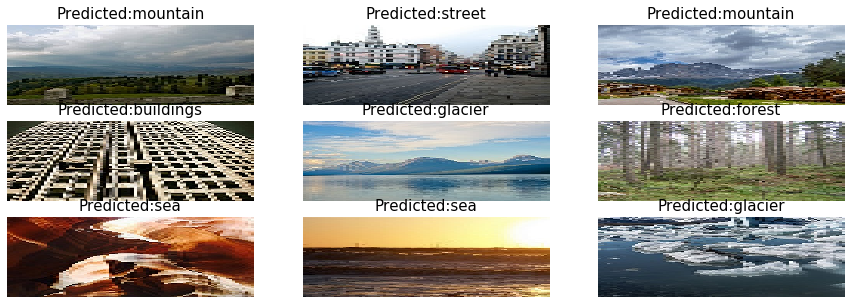

In [46]:
images_to_test = [path_to_test+'\\'+str(onlyfiles[random.randint(1,7301)]) for i in range(9)]
fig     = plt.figure(figsize=(15, 5))
columns = 3
rows    = 3
for i in range(1, columns*rows +1):
    image_path = images_to_test[i-1]
    img        = image.load_img(image_path, target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = img_tensor/255.0
    classes = model.predict_classes(img_tensor, batch_size=batch_sz)
    
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title('Predicted:'+ylabels[classes[0]],fontsize=15)
    plt.imshow(img_tensor[0],aspect='auto',interpolation='nearest')
plt.show()

# Unboxing the blackbox model developed :) 
<div class="alert alert-block alert-success">
We will take a sample image and see how it unfolds in each layer of the CNN developed so far. 
</div>

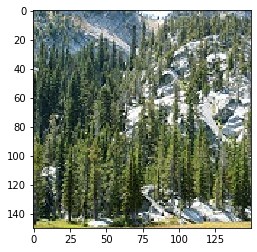

In [114]:
images_to_test = [path_to_test+'\\'+str(onlyfiles[random.randint(1,7301)]) for i in range(1)]
img=mpimg.imread(images_to_test[0])
imgplot = plt.imshow(img)
plt.show()

<div class="alert alert-block alert-success">
We can clearly see that we are able to pick up an image of a forest. Now we see how the features are recognised in each step of the model.
</div>

<div class="alert alert-block alert-success">
    <b>Preprocessing step:- </b> We are preprocessing the data into the form understandable by the model.
</div>

In [115]:

image_path = images_to_test[0]
img        = image.load_img(image_path, target_size=(height, width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor/255.0

<div class="alert alert-block alert-success">
<b>Capturing instances of different layers :</b> We capture the instances of different layers of the model fit.
</div>

In [116]:
layer_outputs        = [layer.output for layer in model.layers] 
model_dev_at_layers  = Model(inputs=model.input, outputs=layer_outputs) 

In [117]:
layer_outputs

[<tf.Tensor 'conv2d_5/Relu:0' shape=(?, 80, 80, 150) dtype=float32>,
 <tf.Tensor 'conv2d_6/Relu:0' shape=(?, 39, 39, 150) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 7, 7, 150) dtype=float32>,
 <tf.Tensor 'conv2d_7/Relu:0' shape=(?, 7, 7, 120) dtype=float32>,
 <tf.Tensor 'conv2d_8/Relu:0' shape=(?, 4, 4, 120) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(?, 1, 1, 120) dtype=float32>,
 <tf.Tensor 'flatten_2/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'dense_5/Relu:0' shape=(?, 150) dtype=float32>,
 <tf.Tensor 'dropout_4/cond/Merge:0' shape=(?, 150) dtype=float32>,
 <tf.Tensor 'dense_6/Relu:0' shape=(?, 120) dtype=float32>,
 <tf.Tensor 'dropout_5/cond/Merge:0' shape=(?, 120) dtype=float32>,
 <tf.Tensor 'dense_7/Relu:0' shape=(?, 60) dtype=float32>,
 <tf.Tensor 'dropout_6/cond/Merge:0' shape=(?, 60) dtype=float32>,
 <tf.Tensor 'dense_8/Softmax:0' shape=(?, 6) dtype=float32>]

In [119]:
outputs_from_layers = model_dev_at_layers.predict(img_tensor) 

In [120]:
outputs=[]
for i in range(5):
    outputs.append(outputs_from_layers[i])

<div class="alert alert-block alert-success">
    <b>First layer</b> We capture the first convolution layer and its output. The shape of the output tensor is given below 
</div>

In [148]:
print('The shape of first layer is ',outputs[0].shape)
print('There are clearly ',outputs[0].shape[3],' channels(features) attained from first layer')

The shape of first layer is  (1, 80, 80, 150)
There are clearly  150  channels(features) attained from first layer


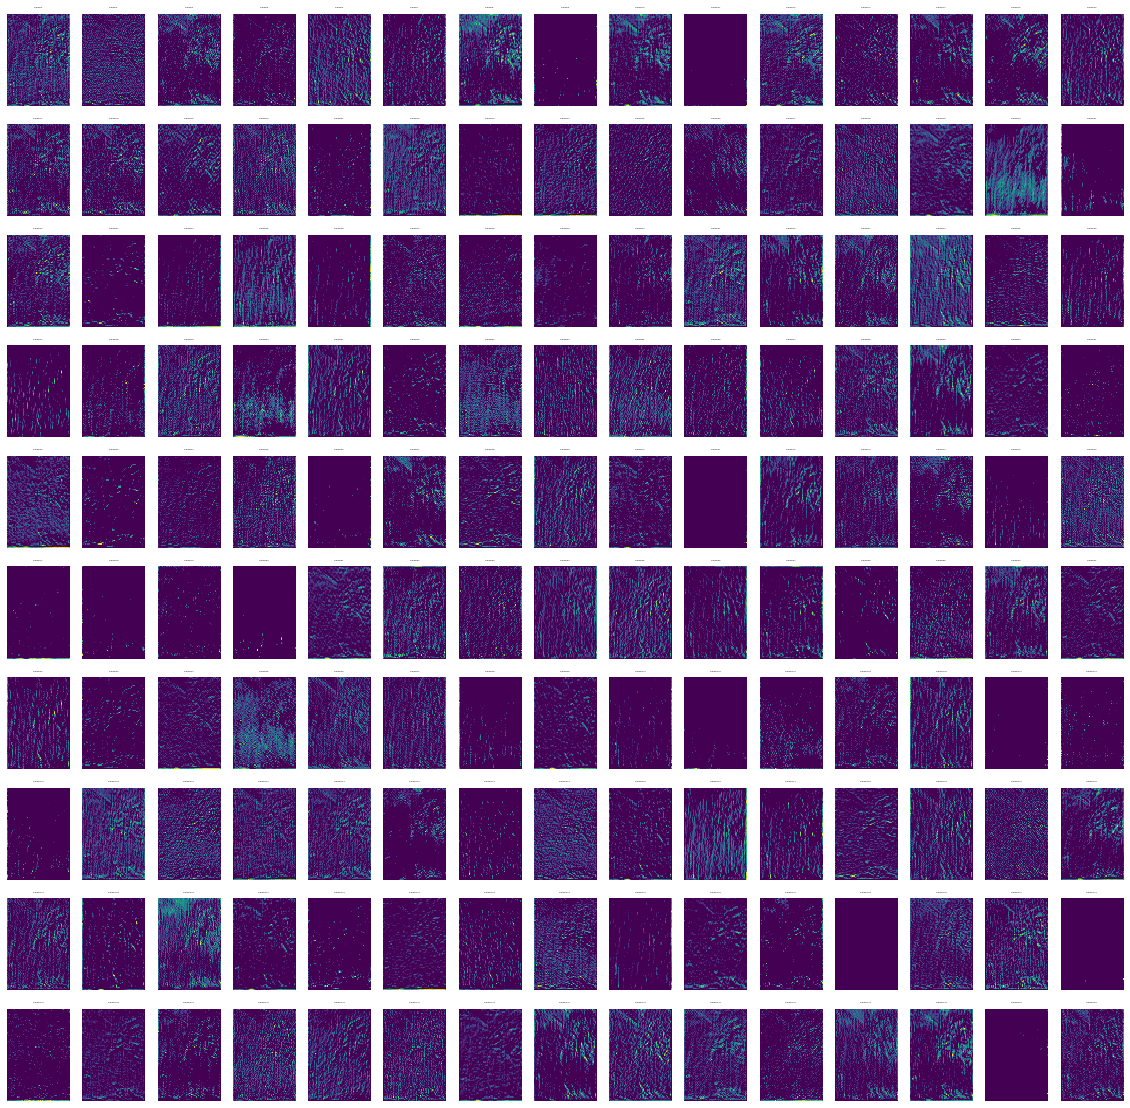

In [121]:
fig     = plt.figure(figsize=(20, 20))
columns = 15
rows    = 10
for i in range(1, columns*rows +1):
    img_tensor = outputs[0][0,:,:,i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title('channel'+str(i+1),fontsize=2)
    plt.imshow(img_tensor,aspect='auto',interpolation='nearest')
plt.show()

<div class="alert alert-block alert-success">
    <b>Second layer</b> We capture the second convolution layer and its output. The shape of the output tensor is given below 
</div>

In [151]:
print('The shape of second layer is ',outputs[1].shape)
print('There are clearly ',outputs[1].shape[3],' channels(features) attained from second layer')

The shape of second layer is  (1, 39, 39, 150)
There are clearly  150  channels(features) attained from second layer


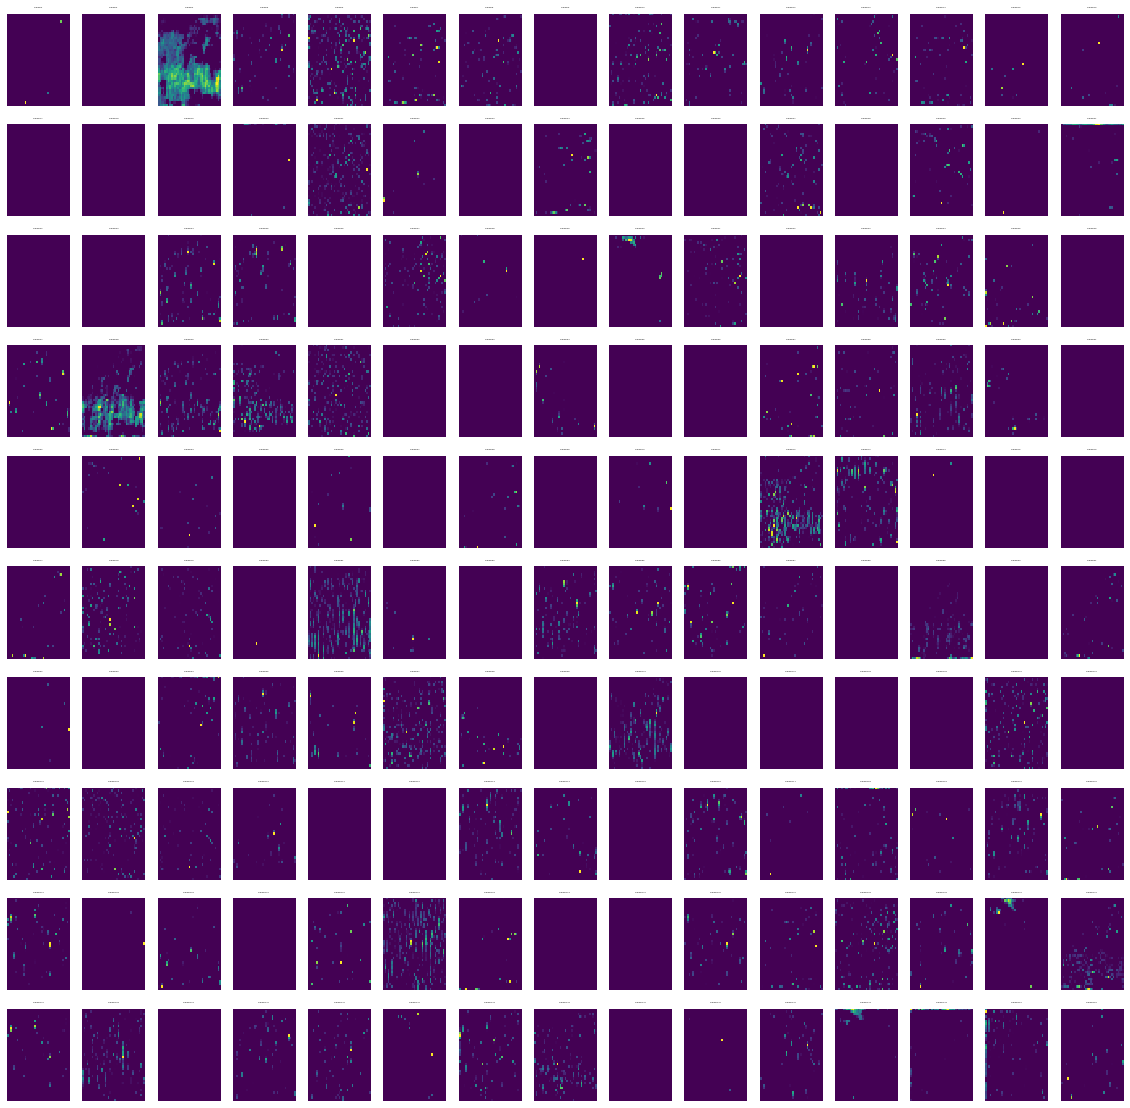

In [122]:
fig     = plt.figure(figsize=(20, 20))
columns = 15
rows    = 10
for i in range(1, columns*rows +1):
    img_tensor = outputs[1][0,:,:,i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title('channel'+str(i+1),fontsize=2)
    plt.imshow(img_tensor,aspect='auto',interpolation='nearest')
plt.show()

<div class="alert alert-block alert-success">
    <b>Third layer</b> We capture the third convolution layer and its output. The shape of the output tensor is given below 
</div>

In [150]:
print('The shape of third layer is ',outputs[1].shape)
print('There are clearly ',outputs[1].shape[3],' channels(features) attained from third layer')

The shape of third layer is  (1, 39, 39, 150)
There are clearly  150  channels(features) attained from third layer


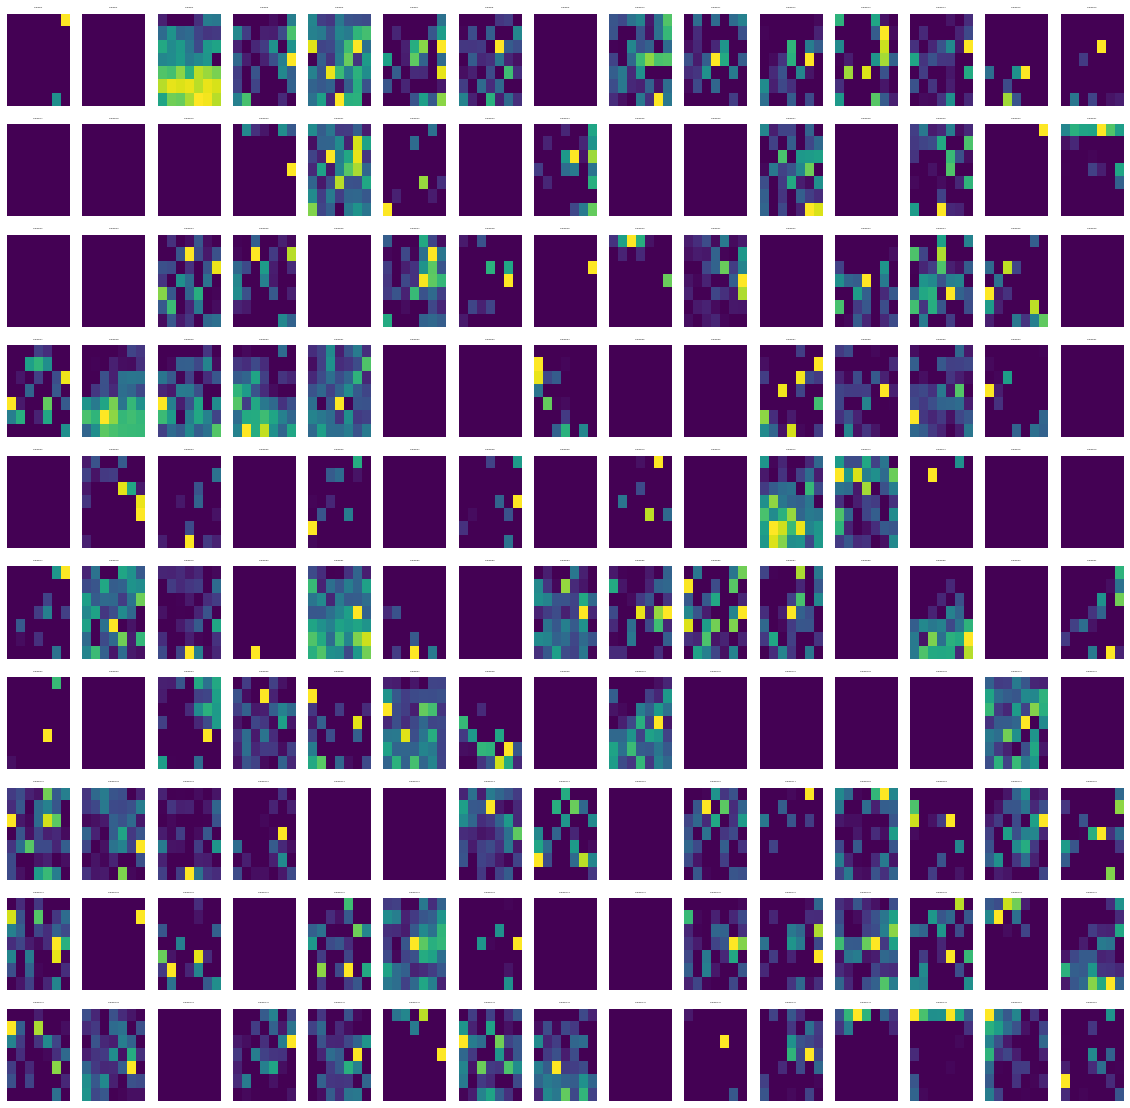

In [123]:
fig     = plt.figure(figsize=(20, 20))
columns = 15
rows    = 10
for i in range(1, columns*rows +1):
    img_tensor = outputs[2][0,:,:,i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title('channel'+str(i+1),fontsize=2)
    plt.imshow(img_tensor,aspect='auto',interpolation='nearest')
plt.show()

<div class="alert alert-block alert-success">
    <b>Fourth layer</b> We capture the Fourth convolution layer and its output. The shape of the output tensor is given below 
</div>

In [153]:
print('The shape of fourth layer is ',outputs[3].shape)
print('There are clearly ',outputs[3].shape[3],' channels(features) attained from fourth layer')

The shape of fourth layer is  (1, 7, 7, 120)
There are clearly  120  channels(features) attained from fourth layer


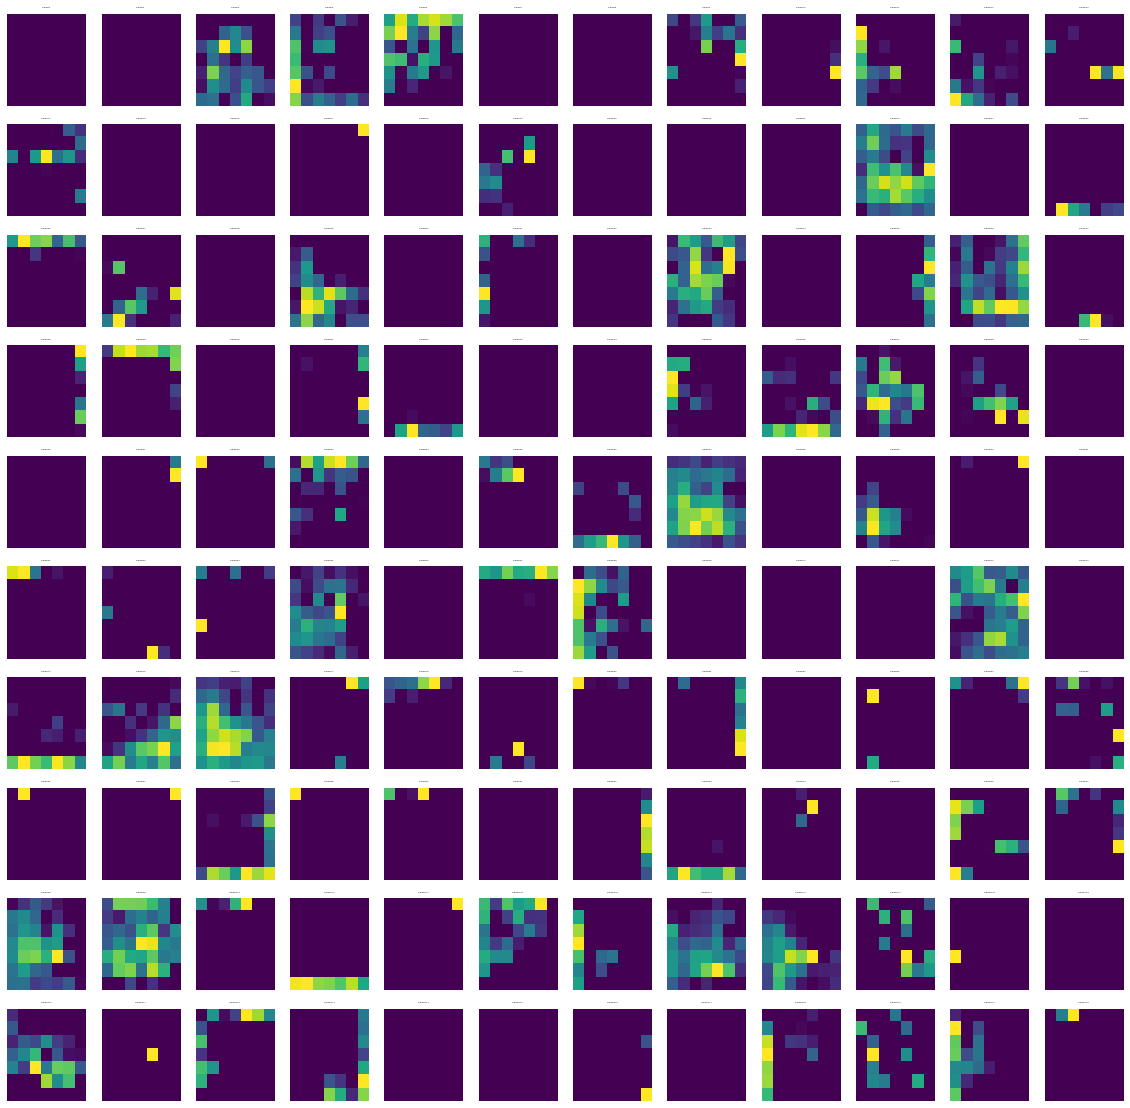

In [125]:
fig     = plt.figure(figsize=(20, 20))
columns = 12
rows    = 10
for i in range(1, columns*rows +1):
    img_tensor = outputs[3][0,:,:,i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title('channel'+str(i+1),fontsize=2)
    plt.imshow(img_tensor,aspect='auto',interpolation='nearest')
plt.show()

<div class="alert alert-block alert-success">
    <b>Fifth layer</b> We capture the Fifth convolution layer and its output. The shape of the output tensor is given below 
</div>

In [154]:
print('The shape of fifth layer is ',outputs[4].shape)

The shape of fifth layer is  (1, 4, 4, 120)


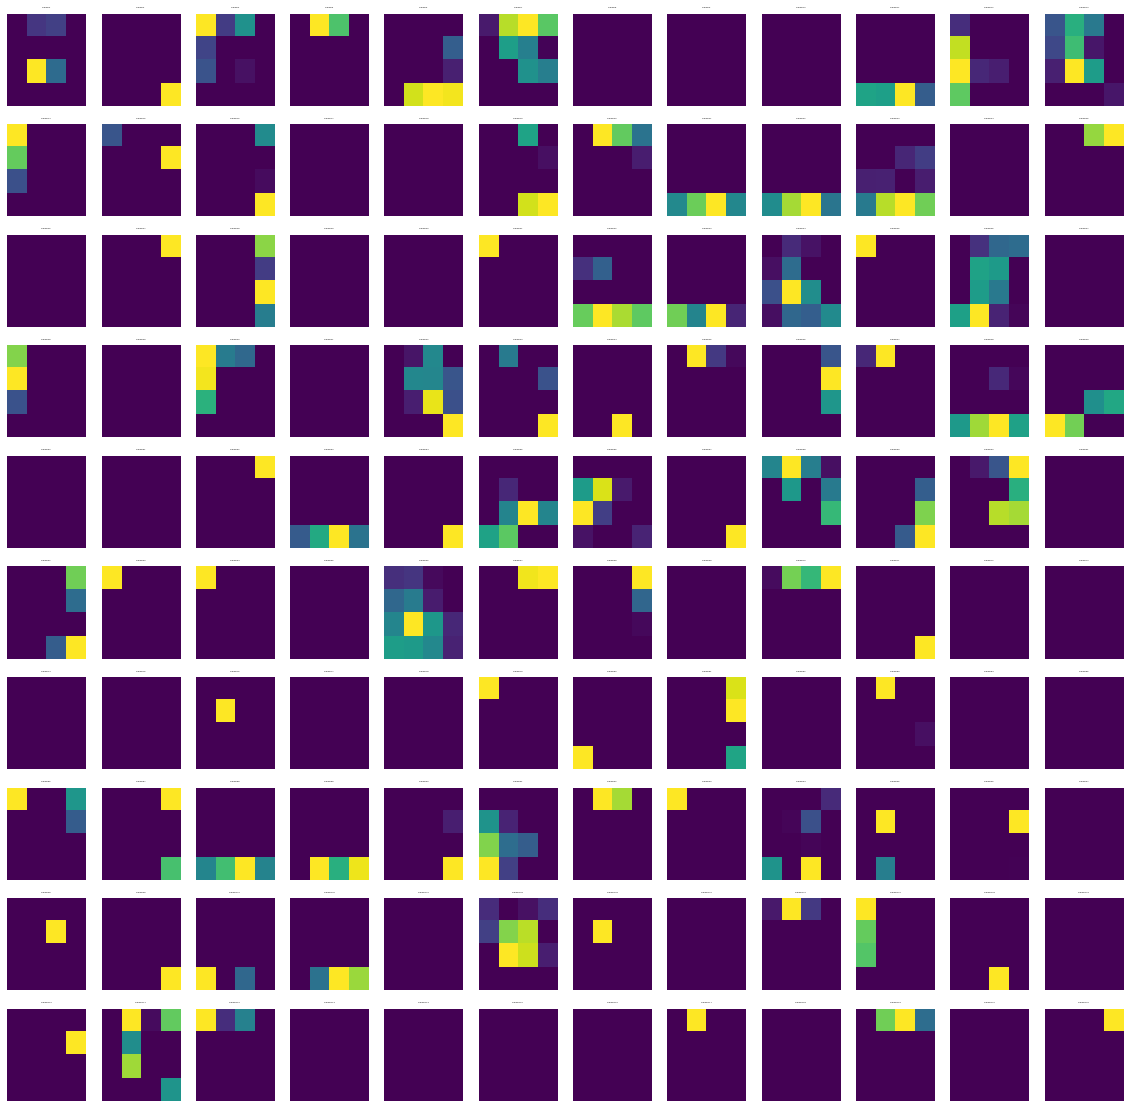

In [127]:
fig     = plt.figure(figsize=(20, 20))
columns = 12
rows    = 10
for i in range(1, columns*rows +1):
    img_tensor = outputs[4][0,:,:,i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title('channel'+str(i+1),fontsize=2)
    plt.imshow(img_tensor,aspect='auto',interpolation='nearest')
plt.show()

<div class="alert alert-block alert-success">
    <b>Final Dense layer</b> We capture the output of final layer. There are many intermediate dense layers in between that are fully connected neural networks and visualizing their outputs won't make any sense, so we straight away jump to the last layer where we are applying softmax function to get probabilities of the different class. The class with maximum probability is represented in the bar graph shown 
</div>

In [136]:
prediction_label = {}
final_layer_output = list(outputs_from_layers[-1][0])
for i in range(len(final_layer_output)):
    prediction_label[ylabels[i]] = final_layer_output[i]

<BarContainer object of 6 artists>

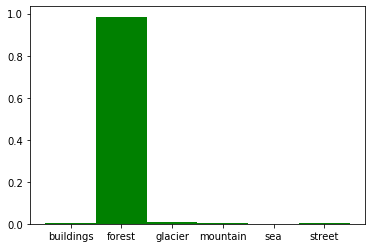

In [145]:
plt.bar(prediction_label.keys(), prediction_label.values(), 1,color='g')

<div class="alert alert-block alert-success">
    <b>Outcome</b> Clearly we are able to see that we get the outcome as Forest which has the maximum probability as expected :) 
</div>